# Running or Importing .py Files with Google Colab

Run these codes first in order to install the necessary libraries and perform authorization.

In [66]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpp_o2x86f/pubring.gpg' created
gpg: /tmp/tmpp_o2x86f/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


mount your Google Drive:

In [67]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# Naive Bayes for Sentiment Analysis

---

*   **Text classification** aims to assign documents (emails, tweets, posts, news, etc) to one or many categories.
*   *Sentiment analysis*, one example of its applications, is to detemine the writer's point of view about a particular topic, product, service, etc

---

In [68]:
import sys
sys.path.append('drive/AI_School_Practice_2018/metacritic/')
!pip install bcolz

In [69]:
import utils
import importlib
# importlib.reload(utils)
from utils import *
import nltk
nltk.download('punkt')


%matplotlib inline

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import re, string, collections, bcolz, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.tokenize.regexp import RegexpTokenizer

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preprocessing

1.   Data scraping
2.   Data cleaning
3.   Exploratory data analysis

## Sentiment analysis


*   Objective: To train a **sentiment analysis classifier** given the games reviews in the dataset. The model must classify text reviews in positive or negative



In [13]:
df = pd.read_csv('drive/AI_School_Practice_2018/metacritic/data/reviews.csv', lineterminator='\n')
# df.shape
print('There\'s %d games reviews.' % df.shape[0])


There's 127699 games reviews.


  Let's keep just text and score columns

In [14]:
df = df[['text', 'score']]
df

,text,score
0,"it makes a terrible first impression, but ult...",74.0
1,brings some fresh and inventive ideas to the ...,65.0
2,a fun main mode of play that can get quite add...,60.0
3,"simply put, feels like half of a game.",60.0
4,"combined with the price and lack of cross-buy,...",60.0
5,"feels like an unfinished product, and it’s a ...",60.0
6,had a lot of love poured into its development...,90.0
7,this game has sparked an interest in anime tha...,85.0
8,"last recode is a very well done compilation, w...",80.0
9,is an incredible package of remastered games....,80.0




---


The data have 127699 reviews but we will keep just the most polarized ones. The filter is the next:

Positive: score > 85

Negative: score < 50


---



In [15]:
print('Review with score greater than 85: %d' % len(df.loc[df["score"] > 85]))
print('Review with score less than 50: %d' % len(df.loc[df["score"] < 50]))

Review with score greater than 85: 43518
Review with score less than 50: 20428


In [0]:
pos = df.loc[df['score'] > 85, 'text'].copy().reset_index(drop=True)
neg = df.loc[df['score'] < 50, 'text'].copy().reset_index(drop=True)

Let's print some positive reviews examples

In [17]:
for i in range(4):
    print(''.join(pos[np.random.randint(0, len(pos))]))
    print('\n')

treyarch's call of duty: black ops 3 offers the most complete and mature campaign we've seen to date, delivers a seamless multiplayer, and brings back the funny zombies mode, which this year comes with a lot of secrets and mysteries to uncover.


 have fun with this game!


 thank you for reading.


 oh, and fyi, you can play 1v1 or 2v2.




Let's print some negative reviews examples

In [18]:
for i in range(4):
    print(''.join(neg[np.random.randint(0, len(neg))]))
    print('\n')

this game was an absolute chore to play through. ridiculous design. shoddy audio and horrendous one song soundtrack on repeat. bland mechanics and repetitive nature just scratch the surface on why i couldn't be paid to download it. "the repetitiveness of levels and enemy encounters, the barebones story, and the constantly frustrating fighting mechanics – the game’s main draw – are all a reminder of how far gaming has come. rather than build on a foundation set by juggernaut titles like the simpsons and x-men,  copies their blueprints exactly as they were"


this is one of the nastiest video games ever made.


let me start off by saying, no game deserves 0 out of 10, if someone put effort into making a game it deserves at least a 1 even if effort is lacking.  this game is that lack of effort, i'm sure the story is pretty solid but i cannot get far enough into it before some experience ruining glitch occurs that brings me back to realizing this game isn't an immersive experience its a ch

We must add the labels: 1 for positive reviews, 0 for negative reviews

In [0]:
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)

Mean, standard deviation and max length of negative reviews

In [20]:
lens = neg['text'].str.len()
lens.mean(), lens.std(), lens.max()

(682.3802134325435, 824.7117020425318, 14736)

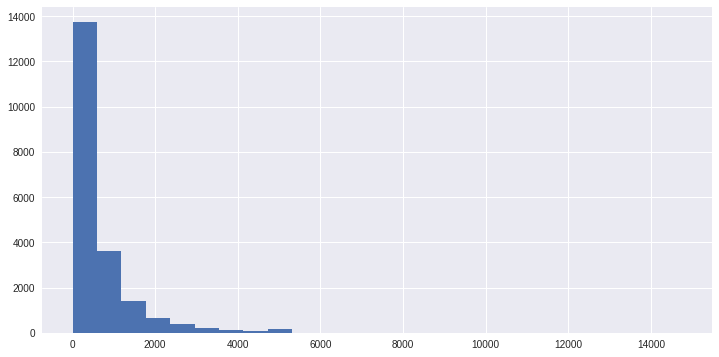

In [21]:
lens.hist(figsize=(12,6), bins=25)

Reviews with more than 5000 characters are dropped

In [0]:
long_reviews = neg.loc[neg['text'].str.len() > 5000].index
neg.drop(long_reviews, inplace=True)

Mean, standard deviation and max length of positive reviews

In [23]:
lens = pos['text'].str.len()
lens.mean(), lens.std(), lens.max()

(586.8897008134566, 739.3522068925535, 25656)

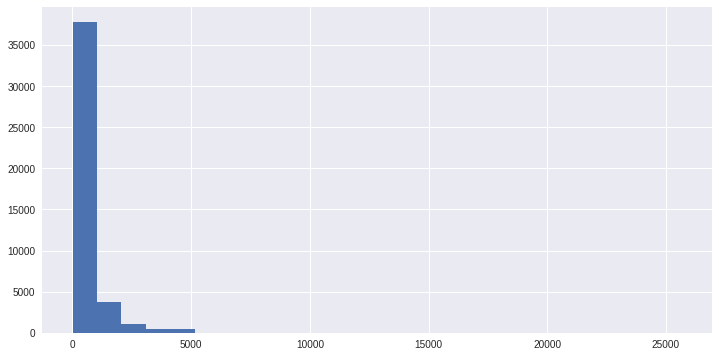

In [24]:
lens.hist(figsize=(12,6), bins=25)

In [0]:
long_reviews = pos.loc[pos['text'].str.len() > 5000].index
pos.drop(long_reviews, inplace=True)

In [26]:
len(neg)

20406

Is desirable to have a balanced dataset (similar quantity of positive and negative instances).

So we will pick a random subset of the positive instances.

In [0]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

In [28]:
pos.shape, neg.shape

((20406, 2), (20406, 2))

We concatenate positive and negative reviews

In [29]:
df = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
df

,text,class
0,seriously ea you remove the add guest feature ...,0.0
1,"’s goal is an admirable one, to capture the fe...",0.0
2,wow wow wow. have been a huge fan of this fra...,1.0
3,first off...i would really give this expansion...,1.0
4,really bad game even for the most hardcore goo...,0.0
5,"dated, immature, repetitive and fun. knows w...",0.0
6,anything less than a perfect score would be lu...,1.0
7,received this game as a gift for christmas. i...,1.0
8,forza motoraport 7 is by far the worst racing ...,0.0
9,is a bit of an oddity. a walking simulator wi...,0.0


In [30]:
df.shape

(40812, 2)

Split data into train and test set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['class'].values, test_size=0.2, random_state=42)

In [32]:
len(X_train), len(X_test), len(y_train), len(y_test)

(32649, 8163, 32649, 8163)

# Preparing the data
Computers do not understand about plain text, so we need to transform our documents into numeric representations.



---


## Tokenization


*   Splitting text into relevant units(characters, words, phrases or others), which are called tokens.
*   For instance:
"a very good game that could have been a lot better" -> ['a', 'very', 'good', 'game', 'that', 'could', 'have', 'been', 'a', 'lot', 'better']

*   There are several tonekizers out there that we can use: spaCy, keras, NLTK, fast.ai, just to name a few.





---

## Bag-of-Words (BoW)



*   Creating a numerical feature vector for each document
*   BoW counts the number of times that tokens appear in every document of the collection.
*   It returns a matrix with the next characteristics:


      1.   Number of columns = number of unique tokens in the whole collection of documents (vocabulary)
      2.   Number of rows = number of documents in the whole collection of documents








---



In [0]:
# vect = CountVectorizer(tokenizer=word_tokenize)
vect = CountVectorizer(tokenizer=RegexpTokenizer("[\w']+").tokenize)

# vect = CountVectorizer(tokenizer=WordPunctTokenizer().tokenize)


tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [0]:
tokenizer=RegexpTokenizer("[\w']+")
vect = CountVectorizer(tokenizer=RegexpTokenizer("[\w']+").tokenize)
# vect = CountVectorizer(analyzer='word', tokenizer=RegexpTokenizer("[\w']+").tokenize,
#                        decode_error='strict', input='content', encoding='utf-8')
tf_train = vect.fit_transform(X_train)

In [0]:
def base_filter():
    f = string.punctuation
    f = f.replace("'", '')
    f += '\t\n'
    return f

In [60]:
re_tok = re.compile( base_filter )
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
vect = CountVectorizer(tokenizer=tokenize)

TypeError: ignored

In [51]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern="[\\w']+", gaps=False, discard_empty=True, flags=56)>,
        vocabulary=None)

In [58]:
tf_train

<32649x47572 sparse matrix of type '<type 'numpy.int64'>'
	with 2415288 stored elements in Compressed Sparse Row format>

In [53]:
vocab = vect.get_feature_names()
vocab[403:408]

[u"'gaming'", u"'gatherers'", u"'gear", u"'geez", u"'get"]

In [164]:
tf_test

<8163x47572 sparse matrix of type '<type 'numpy.int64'>'
	with 590330 stored elements in Compressed Sparse Row format>

32469 training documents, 8163 test documents and 60865 tokens in the vocabulary.

Just a small fraction of tokens are present in each document, so most part of cells are filled with zeros. For efficient storage, sparse matrices are used.

In [169]:
X_train[0]

"as a fan of the metal gear series, particularly 1, 2 and 3, this game has left me disappointed. why is that? first, it's an open world game. now mind you, i have nothing against open world games. open world games can be a blast if done right. since this is the first time metal gear has gone open world, i had high expectations that they'd not only meet but exceed their competitors when it came to creating a world that you actually want to explore. i mean, what is the point of making an open world game if it's not interesting to traverse? if you're not going to do that, just make it a linear game like prior games in the series and perfect each space by littering them full of interesting things to see and do. and here is my first complaint with metal gear solid 5. the open world is uninteresting. you have africa and afghanistan. both overly brown, void of much life, and little to hold your interest while moving throughout the world. while there are side missions sprinkled throughout the 

In [171]:
w0 = set([o for o in X_train[0].split(' ')])
w0

{'&',
 '1,',
 '2',
 '3,',
 '5.',
 'a',
 'about',
 'actors',
 'actors.',
 'actually',
 'actually,',
 'add',
 'afghanistan.',
 'africa',
 'against',
 'agree',
 'all',
 'an',
 'and',
 'another',
 'any',
 'anything',
 'are',
 'are,',
 'as',
 'barely',
 'be',
 'because',
 'been',
 'blast',
 'both',
 'both,',
 'brown,',
 'but',
 'but,',
 'by',
 'by-the-numbers',
 'came',
 'can',
 "can't",
 'case',
 'come',
 'compared',
 'comparison',
 'competitors',
 'complaint',
 'concede',
 'content',
 'copy',
 'created',
 'creating',
 'cutscenes',
 'cutscenes,',
 'david',
 'deserve.',
 'design.',
 'detract',
 'disappoint',
 'disappoint.',
 'disappointed.',
 'dislike.',
 'do',
 'do.',
 'does',
 "doesn't",
 'done',
 'down',
 'each',
 'enjoyable,',
 'enough',
 'enough,',
 'entirely',
 'especially',
 'even',
 'example,',
 'exceed',
 'expectations',
 'explore.',
 'extra',
 'fact',
 'fail',
 'fan',
 'fan,',
 'far',
 'filler',
 'first',
 'first,',
 'floored',
 'for',
 'forgiving',
 'from',
 'full',
 'game',
 'ga

In [172]:
vect.vocabulary_['unless']

44486

In [173]:
tf_train[0, 44486]

0

# Building a classifier

Naive Bayes is a probabilistic learning method based on applying Bayes' theorem. There are some variations of the algorithm but here we will work with Multinomial.

## Multinomial Naive Bayes
Let each row of out term-document training matrix be the feature count vector for training case *i*.

tf_train[i]  # feature count vector for training case *i*

y_train[i]  # label for training case *i*


---



The count vectors are defined as:

*p*=sum of all feature count vectors with label 1

*q*=sum of all feature count vectors with label 0

In [0]:
p = (tf_train[y_train==1].sum(0) + 1).astype('float')
q = (tf_train[y_train==0].sum(0) + 1).astype('float')

Notice that we add 1 to both count vectors to ensure that every token appear at least one time in each class.


---

The log-count ratie *r* is:


In [186]:
r = np.log((p/p.sum()) / (q/q.sum()))  # log-likelihood
b = np.log(len(p)/len(q))  # log-prior

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [190]:
pre_preds = tf_test * r.T + b
preds = pre_preds.T > 0
acc = (preds==y_test).mean()
acc

0.5005512679162073

In [179]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
acc

0.9317652823716771

In [180]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

NameError: ignored

In [0]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

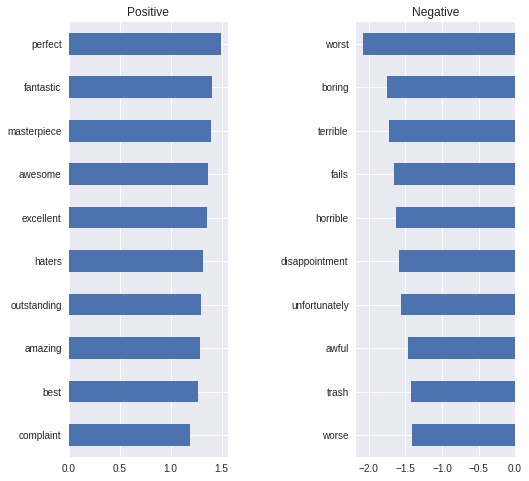

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');